In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split


In [2]:
project_name = 'cifar10-cnn'


In [3]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')


Using downloaded and verified file: .\cifar10.tgz


In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')


In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)


['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor


In [7]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


bird


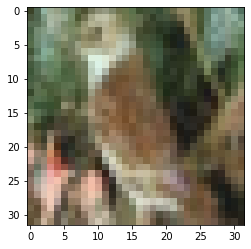

In [9]:
img, label = dataset[11001]
plt.imshow(img.permute(1, 2, 0))
print(dataset.classes[label])


In [10]:
random_seed = 42
torch.manual_seed(random_seed)


In [11]:
train_size = 45000
val_size = 5000
train_ds, val_ds = random_split(dataset, [train_size, val_size])


truck


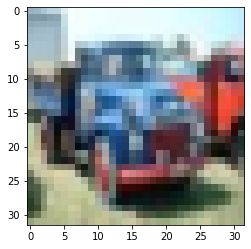

In [12]:
img, label = train_ds[11001]
plt.imshow(img.permute(1, 2, 0))
print(dataset.classes[label])


In [13]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


In [14]:
from torchvision.utils import make_grid


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 10))
        # ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break


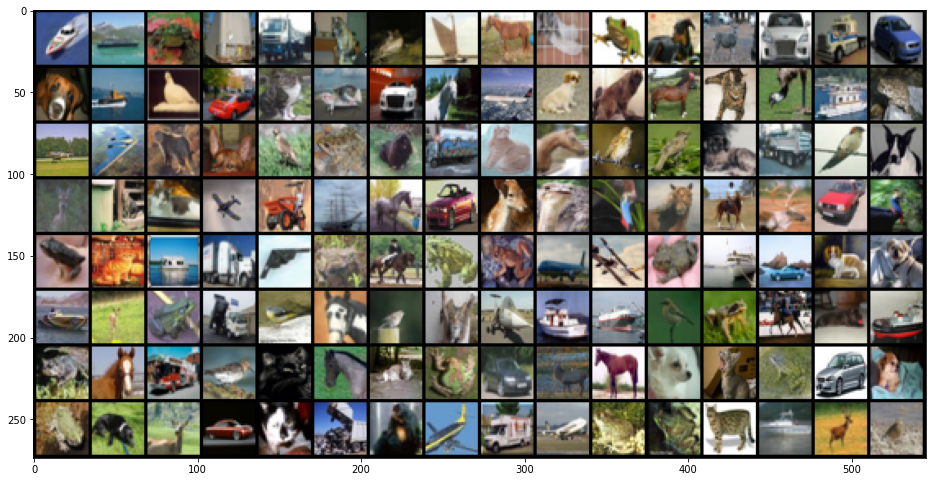

In [15]:
show_batch(train_dl)


In [16]:
import torch.nn as nn
import torch.nn.functional as F


In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [18]:
device = get_default_device()
device


device(type='cpu')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)


In [20]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [21]:
class Cifar10Cnn(ImageClassificationBase):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 3 x 32 x 32
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # 32 x 16 x 16
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # 64 x 8 x 8
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        # 128 x 4 x 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4))
        # 256 x 1 x 1
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.Linear(64, out_channels))

    def forward(self, xb, t=False):
        out = self.layer1(xb)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.classifier(out)

        return out


In [22]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [23]:
model = to_device(Cifar10Cnn(3, 10), device)


In [24]:
model


Cifar10Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_feature

In [25]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01


In [26]:
history = [evaluate(model, val_dl)]


In [27]:
history


[{'val_loss': 2.303520441055298, 'val_acc': 0.10965073108673096}]

In [28]:
%%time
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.8319, val_loss: 1.5968, val_acc: 0.4107
Epoch [1], train_loss: 1.4976, val_loss: 1.4887, val_acc: 0.4620
Epoch [2], train_loss: 1.4022, val_loss: 1.4063, val_acc: 0.4958
Epoch [3], train_loss: 1.3321, val_loss: 1.3349, val_acc: 0.5125
Epoch [4], train_loss: 1.2809, val_loss: 1.3706, val_acc: 0.5131
Epoch [5], train_loss: 1.2697, val_loss: 1.3085, val_acc: 0.5266
Epoch [6], train_loss: 1.2286, val_loss: 1.2462, val_acc: 0.5504
Epoch [7], train_loss: 1.2099, val_loss: 1.2428, val_acc: 0.5588
Epoch [8], train_loss: 1.1697, val_loss: 1.2722, val_acc: 0.5489
Epoch [9], train_loss: 1.1750, val_loss: 1.2754, val_acc: 0.5589
CPU times: total: 39min 10s
Wall time: 11min 50s


In [29]:
%%time
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.1321, val_loss: 1.2173, val_acc: 0.5678
Epoch [1], train_loss: 1.1129, val_loss: 1.1836, val_acc: 0.5854
Epoch [2], train_loss: 1.0934, val_loss: 1.2426, val_acc: 0.5641
Epoch [3], train_loss: 1.0928, val_loss: 1.1627, val_acc: 0.5918
Epoch [4], train_loss: 1.0741, val_loss: 1.2868, val_acc: 0.5548
Epoch [5], train_loss: 1.0577, val_loss: 1.1691, val_acc: 0.5920
Epoch [6], train_loss: 1.0376, val_loss: 1.1259, val_acc: 0.6103
Epoch [7], train_loss: 1.0258, val_loss: 1.1802, val_acc: 0.5926
Epoch [8], train_loss: 1.0099, val_loss: 1.1812, val_acc: 0.5858
Epoch [9], train_loss: 1.0103, val_loss: 1.1833, val_acc: 0.5980
CPU times: total: 34min 42s
Wall time: 11min 23s


In [30]:
%%time
history += fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


Epoch [0], train_loss: 1.0030, val_loss: 1.1680, val_acc: 0.5957
Epoch [1], train_loss: 0.9856, val_loss: 1.2116, val_acc: 0.5940
Epoch [2], train_loss: 0.9964, val_loss: 1.1930, val_acc: 0.5856
Epoch [3], train_loss: 0.9770, val_loss: 1.1536, val_acc: 0.6121
Epoch [4], train_loss: 0.9707, val_loss: 1.2302, val_acc: 0.5828
Epoch [5], train_loss: 0.9695, val_loss: 1.1401, val_acc: 0.6020
Epoch [6], train_loss: 0.9725, val_loss: 1.1540, val_acc: 0.6056
Epoch [7], train_loss: 0.9597, val_loss: 1.1844, val_acc: 0.6016
Epoch [8], train_loss: 0.9512, val_loss: 1.1763, val_acc: 0.6057
Epoch [9], train_loss: 0.9508, val_loss: 1.1880, val_acc: 0.5955
CPU times: total: 32min 23s
Wall time: 10min 24s


In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.title('Accuracy vs Epoch')


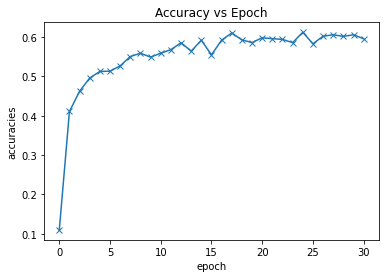

In [32]:
plot_accuracies(history)


In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')


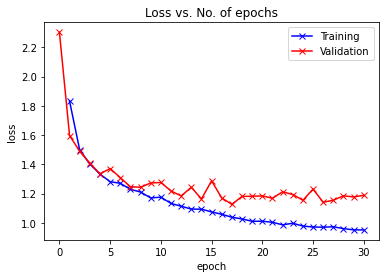

In [34]:
plot_losses(history)


In [35]:
model_children = list(model.children())
model.layer1[0].bias

Parameter containing:
tensor([ 2.6647e-02,  1.2715e-01, -8.4392e-02, -1.6242e-01, -2.0448e-01,
        -1.3578e-01, -8.2799e-02,  1.4871e-01, -8.0086e-02, -4.4362e-03,
        -1.1502e-01, -1.0950e-01, -1.6426e-01, -1.7449e-01, -8.1471e-03,
        -1.4376e-01, -1.9889e-01, -1.1994e-01, -1.6730e-01,  2.9349e-01,
        -6.7386e-02, -2.0073e-01, -1.3433e-01, -1.2599e-01, -2.1161e-01,
        -1.2522e-01, -9.6963e-05, -7.6220e-02,  3.8396e-01, -9.4602e-02,
        -1.4982e-01, -2.0350e-01], requires_grad=True)

In [36]:
model_weights =[]
conv_layers = []
model_children = []
model_weights.append(model.layer1[0].weight)
model_weights.append(model.layer2[0].weight)
model_weights.append(model.layer3[0].weight)
model_weights.append(model.layer4[0].weight)
conv_layers.append(model.layer1[0])
conv_layers.append(model.layer1[1])
conv_layers.append(model.layer1[2])
conv_layers.append(model.layer2[0])
conv_layers.append(model.layer2[1])
conv_layers.append(model.layer2[2])
conv_layers.append(model.layer3[0])
conv_layers.append(model.layer3[1])
conv_layers.append(model.layer3[2])
conv_layers.append(model.layer4[0])
conv_layers.append(model.layer4[1])
conv_layers.append(model.layer4[2])
counter=4

In [37]:
test_dataset=ImageFolder(data_dir+'/test',transform=ToTensor())
train_dataset=ImageFolder(data_dir+'/train',transform=ToTensor())

torch.Size([3, 32, 32])

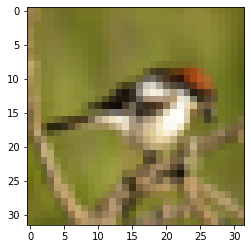

In [43]:
image,label=test_dataset[2954]
plt.imshow(image.permute(1,2,0))
image.shape

In [44]:
image=image.unsqueeze(0)

In [45]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

12
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 16, 16])
torch.Size([1, 64, 8, 8])
torch.Size([1, 128, 8, 8])
torch.Size([1, 128, 8, 8])
torch.Size([1, 128, 4, 4])
torch.Size([1, 256, 4, 4])
torch.Size([1, 256, 4, 4])
torch.Size([1, 256, 1, 1])


In [46]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale/ feature_map.shape[1]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(16, 16)
(16, 16)
(16, 16)
(8, 8)
(8, 8)
(8, 8)
(4, 4)
(4, 4)
(4, 4)
(1, 1)


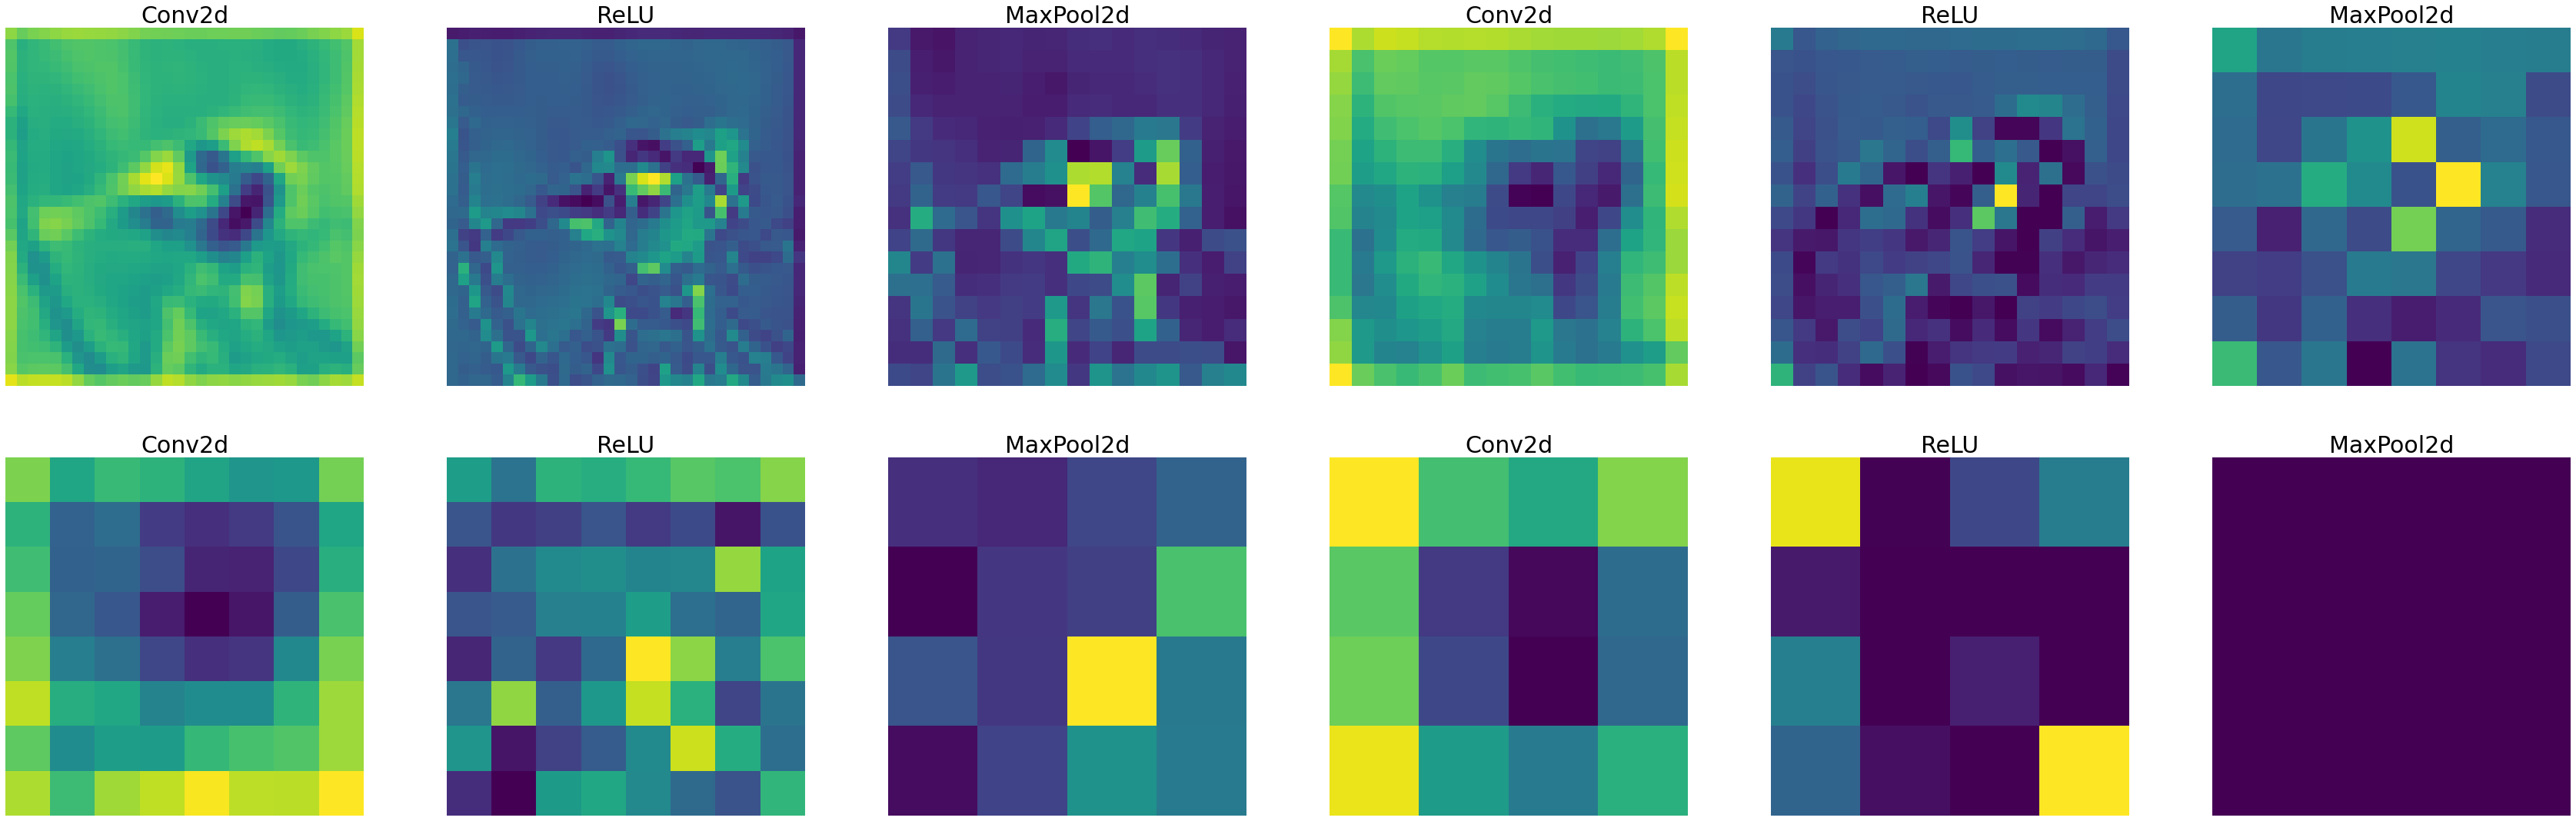

In [47]:
fig = plt.figure(figsize=(60, 60))
for i in range(len(processed)):
    a = fig.add_subplot(6,6, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

(1000, 655)

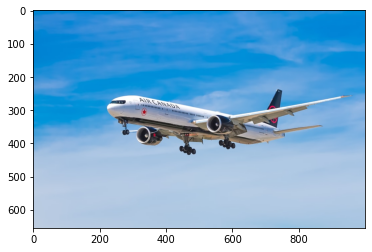

In [55]:
from PIL import Image
image=Image.open('aeroplane.jpeg')

plt.imshow(image)
image.size

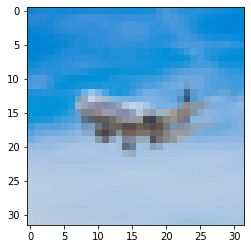

In [58]:
import torchvision.transforms as T
transform=T.Resize(size=(32,32))
img=transform(image)
plt.imshow(img)

In [68]:
def predict_image(image,model):
    xb=to_device(image,device)
    yb=model(image)
    _,preds=torch.max(torch.softmax(yb,dim=1),dim=1)
    return dataset.classes[preds[0].item()]

In [69]:
predict_image(img,model)

AttributeError: to